In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sy

from scipy.optimize import curve_fit

import pandas as pd  # data parsing library
from matplotlib import cm, colors

from glob import glob

from scipy.stats.stats import pearsonr

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
filename = './data/AllRun.txt'

df = pd.read_csv(filename,delimiter='\t', header=0, usecols=['date','lat','alt','H','E'],
                 )  


#df = df.set_index('date')


pearson:  (0.99457849681189492, 4.5896875707988973e-30) (0.91703002148363877, 2.1674990304340814e-20)
aproximation coeficients:  [ 0.13473678 -0.20632176]


/usr/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


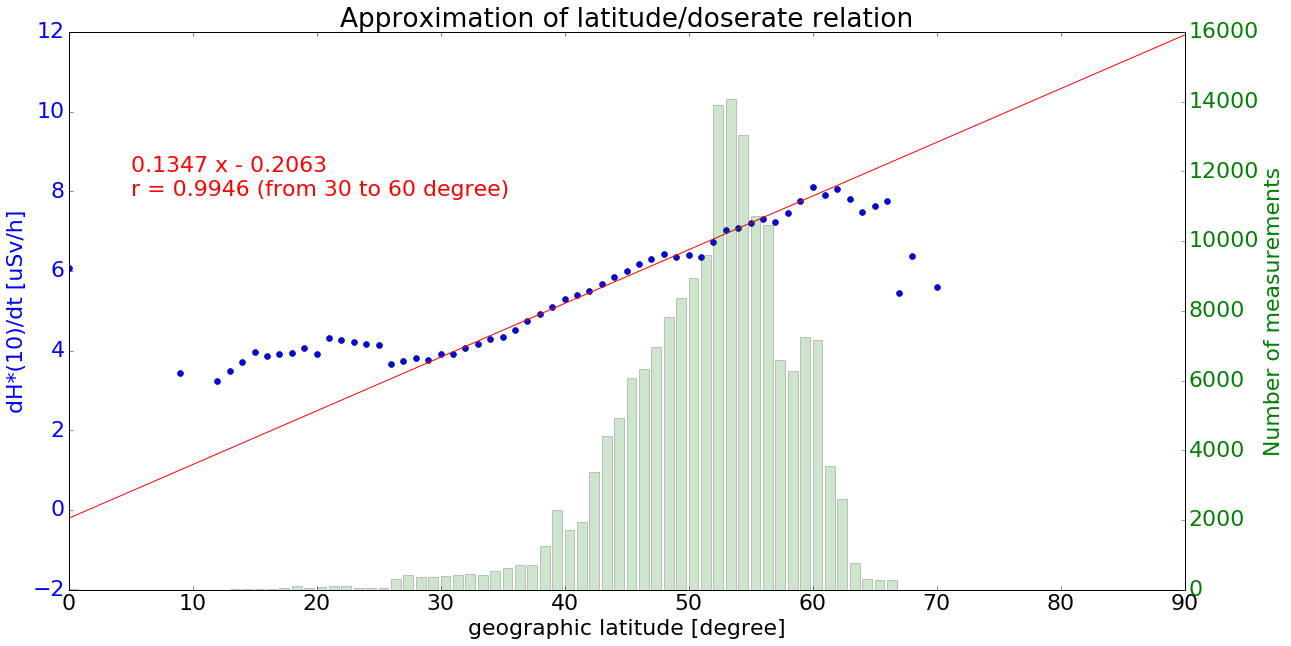

In [4]:
# find latitude relation

plt.figure(figsize=(20, 10))
matplotlib.rcParams.update({'font.size': 22})

lat_rad = np.zeros(90)
lat_num = np.zeros(90)

# sum radiation for one degree
for i in range(len(df)):
    if (df['H'][i]) > 3:
        if (df['alt'][i]) > 33000:
            lat_rad[int(round(df['lat'][i]))] += df['H'][i]
            lat_num[int(round(df['lat'][i]))] += 1
            
# average calculation
for i in range(90):
    lat_rad[i] /= lat_num[i]
            
plt.plot(lat_rad[0:90],'o')
    
pf_coef = np.polyfit(range(30,61),lat_rad[range(30,61)],1)     # linear aproximation

p = np.poly1d(pf_coef)
r = pearsonr(p(range(30,61)),lat_rad[range(30,61)])
rr = pearsonr(p(range(20,69)),lat_rad[range(20,69)])

print 'pearson: ', r, rr
print 'aproximation coeficients: ', pf_coef    # aproximation coeficients 

plt.plot(sy.linspace(0,90), p(sy.linspace(0,90)), 'r-')
plt.xlabel('geographic latitude [degree]')
plt.ylabel('dH*(10)/dt [uSv/h]', color='blue')
plt.tick_params(axis='y', colors='blue')
plt.title('Approximation of latitude/doserate relation') 
plt.twinx()
#plt.plot(lat_num, linestyle='--', color='green')
plt.bar(range(0,80),lat_num[range(0,80)], color='green', alpha=0.2)

plt.ylabel('Number of measurements',color='green')
plt.legend()
plt.tick_params(axis='y', colors='green')
plt.text(5,12000,np.poly1d(pf_coef),color='r')
plt.text(5,11300,'r = ' + str(round(r[0],4)) + ' (from 30 to 60 degree)',color='r')

In [27]:
print p(30), lat_rad[30]
print p(35), lat_rad[35]
print p(40), lat_rad[40]

3.85104041881 3.92558722272
4.51683194407 4.3508880112
5.18262346933 5.29335803619


(0.990913893237233, 1.5041155172008135e-05) (0.9929174337503015, 1.0915527702361591e-08)


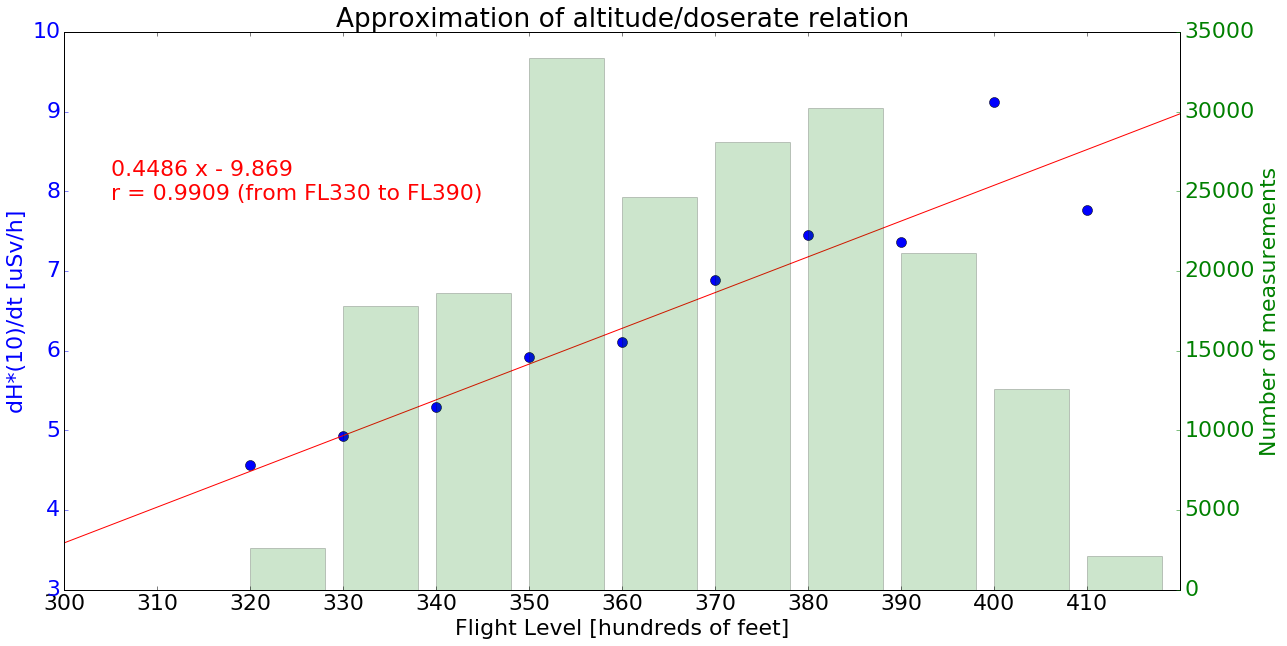

In [5]:
# find altitude relation

plt.figure(figsize=(20, 10))
matplotlib.rcParams.update({'font.size': 22})
#%pylab qt
alt_rad = np.zeros(42)
alt_num = np.zeros(42)


# sum radiation for layers per 1000-th feet
for i in range(len(df)):
    if (df['H'][i]) > 3:
        if (df['alt'][i]) > 32000:
            alt_rad[int(round(df['alt'][i] / 1000))] += df['H'][i]
            alt_num[int(round(df['alt'][i] / 1000))] += 1
            
# average calculation
for i in range(len(alt_rad)):
    alt_rad[i] /= alt_num[i]
            
plt.xlabel('Flight Level [hundreds of feet]')
plt.tick_params(axis='y', colors='blue')#, which='both', width=3, labelleft='on', labelright='off', left='on', right='off')
plt.plot(alt_rad,'o', markersize=10)
    
ppf_coef = np.polyfit(range(33,40),alt_rad[range(33,40)],1)       # linear aproximation

pp = (np.poly1d(ppf_coef))

r = pearsonr(p(range(33,40)),lat_rad[range(33,40)])
rr = pearsonr(p(range(32,42)),lat_rad[range(32,42)])
print r, rr

plt.plot(sy.linspace(30,42), pp(sy.linspace(30,42)), 'r-')
plt.ylabel('dH*(10)/dt [uSv/h]', color='blue')
#plt.tick_params(axis='y', colors='blue')
plt.title('Approximation of altitude/doserate relation') 

x = range(30,42)
labels= map(str,range(300,420,10))
plt.xticks(x, labels)


plt.twinx()

#plt.plot(range(30,42), alt_num[range(30,42)], linestyle='--', color='green')
plt.tick_params(axis='y', colors='green')#, which='both', width=3, labelleft='off', labelright='on', left='off', right='on')
plt.bar(range(30,42), alt_num[range(30,42)], color='green', alpha=0.2)
plt.ylabel('Number of measurements',color='green')
#plt.tick_params(axis='y', colors='green')
plt.text(30.5,26000,np.poly1d(ppf_coef),color='r')
plt.text(30.5,24500,'r = ' + str(round(r[0],4)) + ' (from FL330 to FL390)',color='r')
        

In [100]:
ppf_coef

array([ 0.44861623, -9.86923384])

## subtract latitude and altitude relation


In [7]:
# subtract latitude and altitude relation

# copy specific columns
df1 = df[['date','H','alt','lat','E']]

#df1.loc[df1.H <= 3, 'HH'] = np.NAN   # filtering of low radiation
df1['date'] = pd.to_datetime(df1['date'])
df1['HH'] = df1['H'] - p(df1['lat']) # subtract latitude relation
df1['HH'] = df1['HH'] - pp(df1['alt'] / 1000)  # subtract altitude relation
df1.loc[df1.alt <= 32000, 'HH'] = np.NAN   # filtering for low altitudes (9 754 m)

df1 = df1.set_index('date')
df1 = df1.sort_index()

df1.to_csv('./radiation.csv') # save data 

# resample measurements 
df2 = pd.read_csv('./radiation.csv', sep=',', header=0)#, parse_dates='time' )
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2.set_index('date')
#df2 = df2.resample('10Min', how='mean', base=0)
df2 = df2.resample('12H', how='mean', base=0)

df2.to_csv('./radiation_avg.csv') # save avaraged data


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


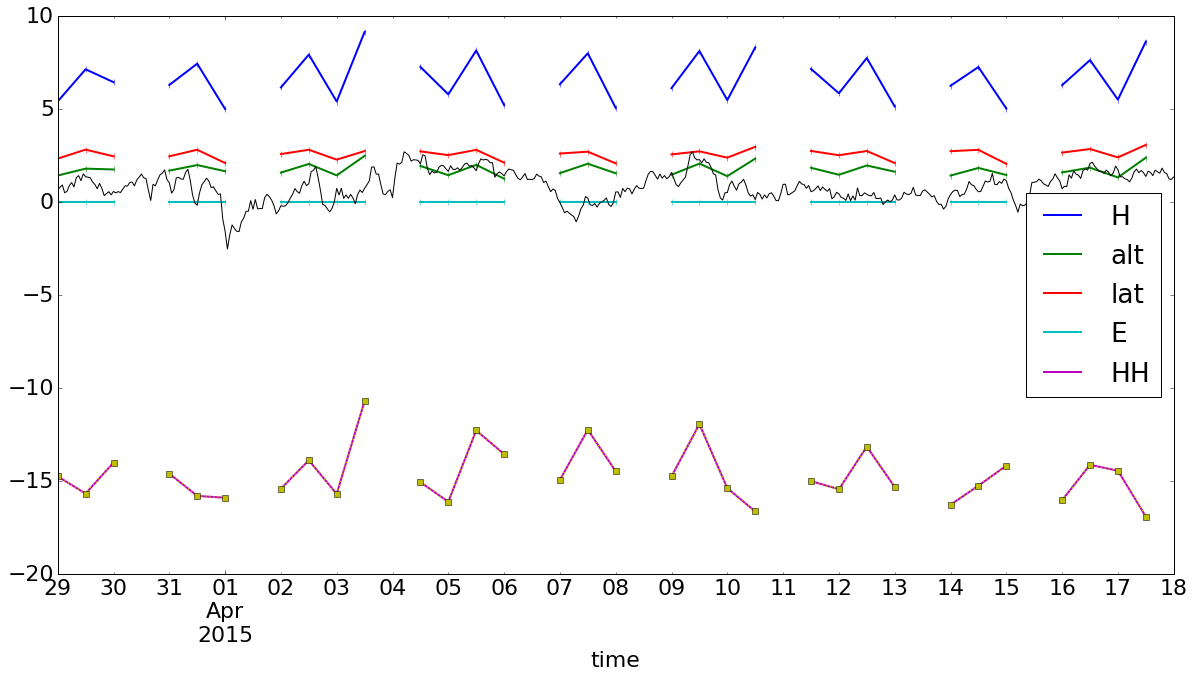

In [8]:
# subtract latitude and altitude relation and plot given date

# copy specific columns
df1 = df[['date','H','alt','lat','E']]

#df1.loc[df1.H <= 3, 'HH'] = np.NAN   # filtering of low radiation
df1['date'] = pd.to_datetime(df1['date'])
df1['HH'] = df1['H'] - p(df1['lat']) # subtract latitude relation
df1['HH'] = df1['HH'] - pp(df1['alt'] / 1000)  # subtract altitude relation
df1.loc[df1.alt <= 32000, 'HH'] = np.NAN   # filtering for low altitudes

df1 = df1.set_index('date')
df1 = df1.sort_index()

df1.to_csv('./radiation.csv') # save data 

# resample measurements 
df2 = pd.read_csv('./radiation.csv', sep=',', header=0)#, parse_dates='time' )
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2.set_index('date')
#df2 = df2.resample('10Min', how='mean', base=0)
df2 = df2.resample('12H', how='mean', base=0)

df2.to_csv('./radiation_avg.csv') # save avaraged data

# plot data for given date

#FD = '2001-11-6'
#FD = '2005-12-12'
#FD = '2012-3-8'
FD = '2015-4-8'

df3 = pd.read_csv('./LSradiation.csv', sep=',', header=0)#, parse_dates='time')
df3['time'] = pd.to_datetime(df3['time'])
df3 = df3.set_index('time')
df3 = df3.sort_index()

df2 = pd.read_csv('./radiation_avg.csv', sep=',', header=0)#, parse_dates='time' )
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2.set_index('date')
df2['H'] = df2['H'].astype(float)
df2['HH'] = df2['HH'].astype(float) * 5 + 20

df2['lat'] = df2['lat'] / 20
df2['alt'] = (df2['alt'] - 30000) / 4000

        
datetime.timedelta(days=1)
from_time = str(pd.to_datetime(FD) + datetime.timedelta(days=-10))
to_time = str(pd.to_datetime(FD) + datetime.timedelta(days=10))

#df2[from_time: to_time].plot(figsize=(20,10),title=FD, marker='s',linestyle=':')
df2[from_time: to_time].plot(figsize=(20,10),lw='2',marker='|')
df2['HH'][from_time: to_time].plot(figsize=(20,10),lw='2', marker='s',linestyle=':')
df3[from_time: to_time]['FD'] = df3[from_time: to_time]['FD'].sub(90)
df3[from_time: to_time]['FD'].plot(figsize=(20, 10))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


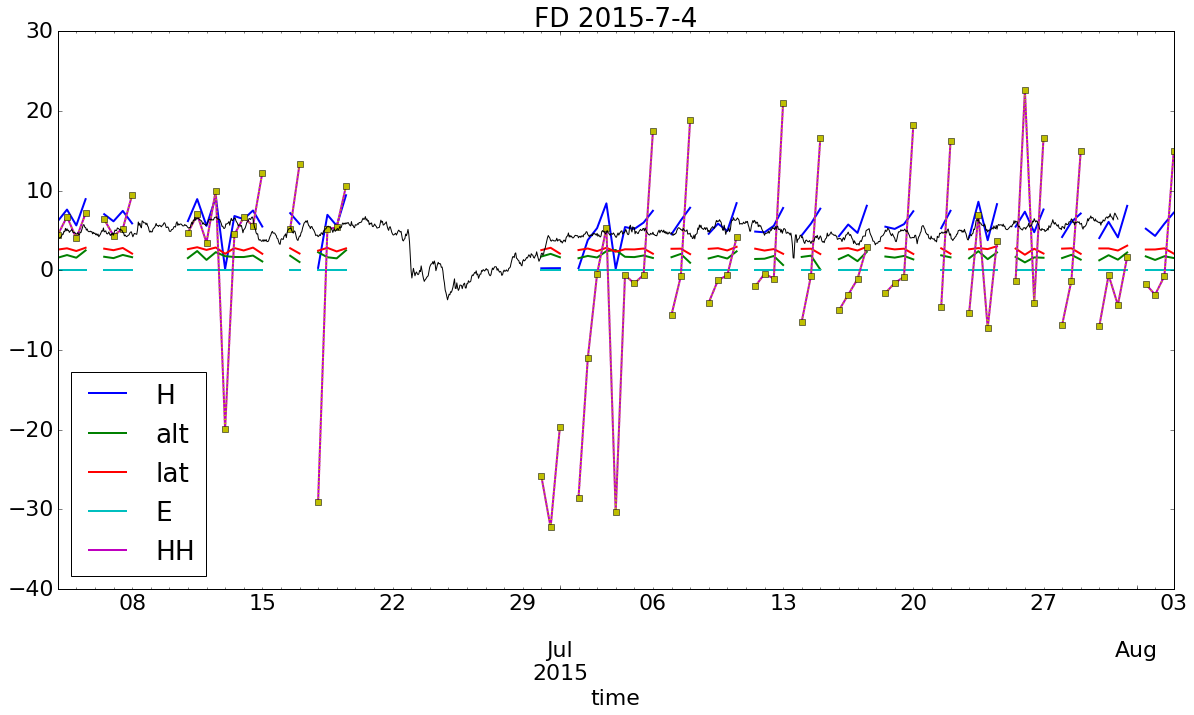

In [10]:
#FD = '2001-5-1'
#FD = '2012-9-4'
FD = '2015-7-4'

days_view = 30


df3 = pd.read_csv('./LSradiation.csv', sep=',', header=0, parse_dates='time')
df3['time'] = pd.to_datetime(df3['time'])
df3 = df3.set_index('time')
df3 = df3.sort_index()

df2 = pd.read_csv('./radiation_avg.csv', sep=',', header=0, parse_dates='time' )
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2.set_index('date')
df2['H'] = df2['H'].astype(float)
df2['HH'] = df2['HH'].astype(float) * 5 + 40

df2['lat'] = df2['lat'] / 20
df2['alt'] = (df2['alt'] - 30000) / 4000

        
datetime.timedelta(days=1)
from_time = str(pd.to_datetime(FD) + datetime.timedelta(days=-days_view))
to_time = str(pd.to_datetime(FD) + datetime.timedelta(days=days_view))

#df2[from_time: to_time].plot(figsize=(20,10),title=FD, marker='s',linestyle=':')
df2[from_time: to_time].plot(figsize=(20,10),lw='2')
df2['HH'][from_time: to_time].plot(figsize=(20,10),lw='2', marker='s',linestyle=':')
df3[from_time: to_time]['FD'] = df3[from_time: to_time]['FD'].sub(90)
df3[from_time: to_time]['FD'].plot(figsize=(20, 10))
plt.title('FD ' + FD)  


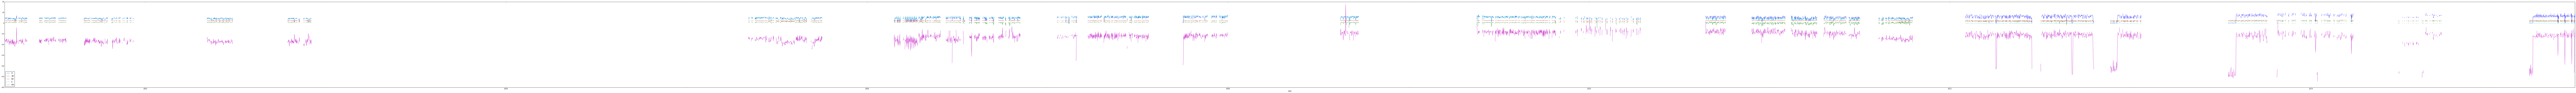

In [19]:
# all data plot

#%pylab qt

df2.plot(figsize=(300, 10))
#df3.plot(figsize=(20, 4))

In [64]:
# MAP

import cartopy.crs as ccrs  # maps plotting library
from cartopy.io.img_tiles import GoogleTiles
#from cartopy.io.img_tiles import OSMx[0:1]
from cartopy.io.srtm import srtm_composite

filename = './data/AllRun.txt'

df = pd.read_csv(filename,delimiter='\t', header=0, usecols=['date','lat','lon','alt','H'])
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

print filename

plt.figure(figsize=(20, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
#ax.set_extent([-10, +140, 0, +90])
ax.set_extent([-160, +160, -90, +90])
#gg_tiles = GoogleTiles()
#gg_tiles = OSM()
#ax.add_image(gg_tiles, 4)
ax.coastlines()
#df = pd.read_csv(filename,sep=',', header=0 )
#df = df[df['0']>10]


#plt.scatter(lon, lat, marker=(5, 1), color='red', s=200)
#plt.title("date: " + date)
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = False

ax = plt.axes(projection=ccrs.PlateCarree())
#!!!!podkladova mapa ax.stock_img()

df = df.resample('1H', how='mean', base=0)

for i in range(len(df)):
    if df['H'][i] > 0:
        if df['alt'][i] > 32000:
            plt.plot(df['lon'][i], df['lat'][i],
                 color=plt.cm.jet(df['H'][i]/10), 
                 marker='.',
                 transform=ccrs.PlateCarree(), #lw=3
                 )

sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=10))
sm._A = []
cb = plt.colorbar(sm, shrink=0.7)
cb.set_label('H*(10)[uSy/h]')
plt.show()




ImportError: No module named cartopy.crs

In [74]:
range(33,38)

[33, 34, 35, 36, 37]